# Map of sub-domain of ANHA12

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import matplotlib
import pickle

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

isize = imax-imin
jsize = jmax-jmin

# runoff period:
rf_year  = 2010
rf_month = 8    # september 

# Resolution of grid cells to show in figure:
grid_reso = 10

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1600,imax,jmax,jmax) # Northern Canada Basin
bdy_WCB = (imax,imax,391,jmax)  # Western Canada Basin
bdy_BB  = (imin,imin,449,674)   # Baffin Bay
bdy_HB  = (1189,1474,291,291)   # Hudson Bay

# colours:
color_glacier   = '#0873b4'
color_continent = '#d67434' 
color_other     = 'w' #'#515151'
light_land      = '#d0d0cf'
light_land_edge = '#929291'

#### Load files:

In [3]:
mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = np.array(mesh.variables['hdept'][0])

mask         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = np.array(mask.variables['nav_lon'])
mesh_lat     = np.array(mask.variables['nav_lat'])
mesh_bathy   = np.array(mask.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mask.variables['nav_lev'])

In [4]:
# ANHA12 river runoff forcing:
rf_file = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y{rf_year}.nc','r')
model_lons = np.array(rf_file.variables['nav_lon'])
model_lats = np.array(rf_file.variables['nav_lat'])
model_river= np.array(rf_file.variables['runoff'])
rf = model_river[rf_month]

# Place NaNs where there is no runoff
rf[rf == 0]       = np.nan
model_lons[rf == 0.0] = np.nan
model_lats[rf == 0.0] = np.nan

In [5]:
# River classification file
# 1. Glaciers
# 2. Continental
# 3. Other
ncd         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb-202207-forcing/river_class-202207.nc')
river_class = np.array(ncd.variables['rclass'])

#### Figure:

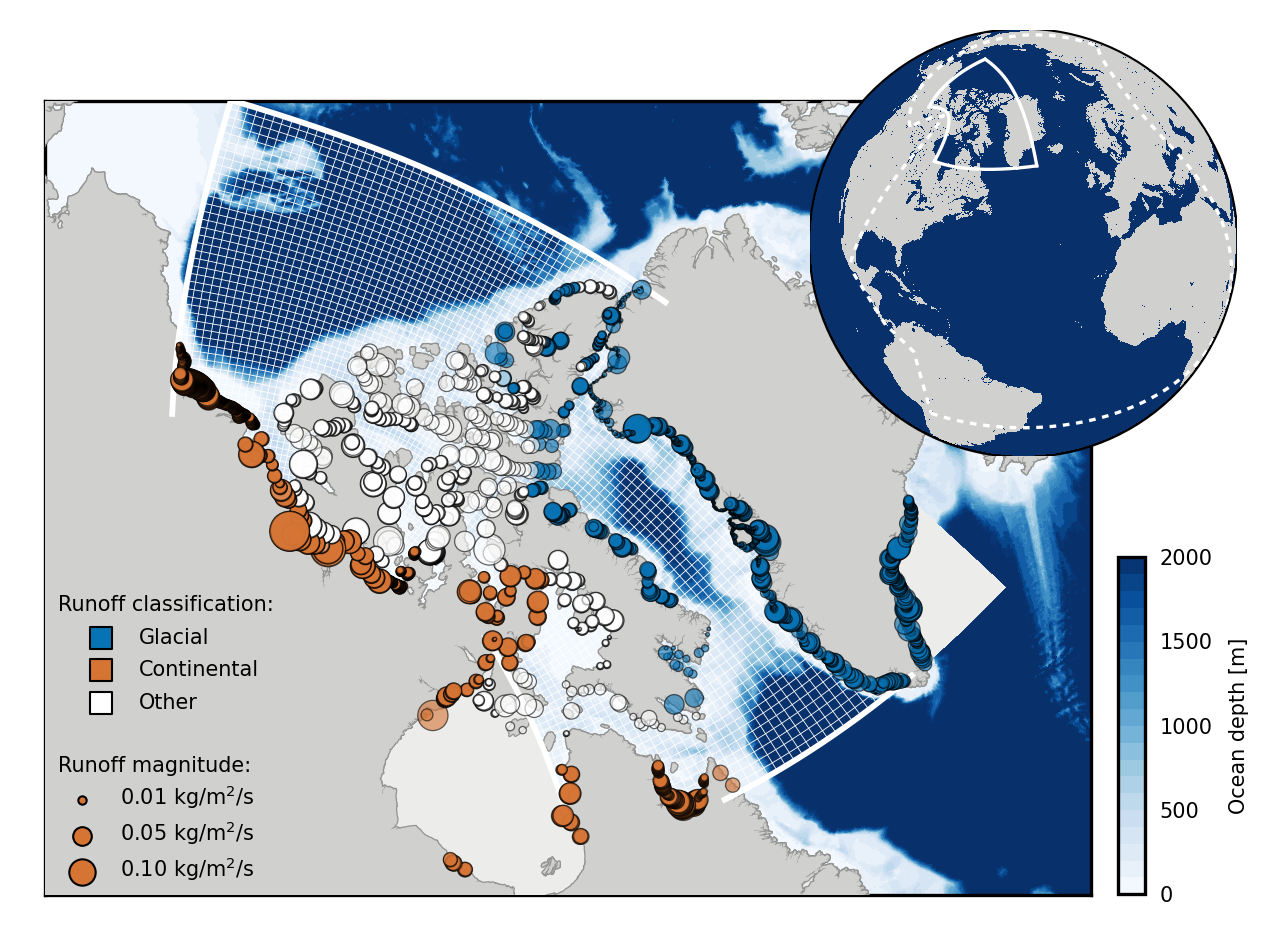

In [6]:
fig, ax1, proj1, ax2, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-map-globe.pickle','rb'))

# Globe: --------------------------------------------------------------------------------------
x, y  = proj2(mesh_lon, mesh_lat) 

# Sub-domain
proj2.plot(x[imin:imax,jmin], y[imin:imax,jmin], 'w-', lw=0.8, zorder=3)
proj2.plot(x[imin:imax,jmax], y[imin:imax,jmax], 'w-', lw=0.8, zorder=3)
proj2.plot(x[imin,jmin:jmax], y[imin,jmin:jmax], 'w-', lw=0.8, zorder=3)
proj2.plot(x[imax,jmin:jmax], y[imax,jmin:jmax], 'w-', lw=0.8, zorder=3)
# full domain
proj2.plot(x[460:-1:grid_reso,0]  , y[460:-1:grid_reso,0]  , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
proj2.plot(x[0,370:-1:grid_reso]  , y[0,370:-1:grid_reso]  , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
proj2.plot(x[100:-1:grid_reso,-1] , y[100:-1:grid_reso,-1] , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
proj2.plot(x[-1,0:-1:grid_reso]   , y[-1,0:-1:grid_reso]   , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
xline_add = [x[500,0], x[700,70], x[1100,0], x[0,370]]
yline_add = [y[240,-1], y[85,-80], y[80,0], y[0,370]]
proj2.plot(xline_add, yline_add, 'w--', lw=0.8, zorder=3, dashes=(2, 2))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# masked areas
hdept_plot = np.ma.masked_where(hdept >2000, hdept)
bath = proj1.contourf(x_sub, y_sub, hdept_plot, 20, cmap=matplotlib.cm.get_cmap('Blues'), vmin=0, vmax=2000, zorder=1)
proj1.contourf(x_sub, y_sub, bathy_masked[0,:,:], colors=['#ececeb'], zorder=4) # land mask

# grid:
x_grid_plot = np.ma.masked_where((mesh_bathy[0,:,:] < 0.1), x_sub)
y_grid_plot = np.ma.masked_where((mesh_bathy[0,:,:] < 0.1), y_sub)
proj1.plot(x_sub[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso]  , \
           y_sub[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso]  , 'w-', lw=0.2, zorder=3);
proj1.plot(x_sub[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso].T, \
           y_sub[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso].T, 'w-', lw=0.2, zorder=3);

# River runoff:
x_rf, y_rf = proj1(model_lons, model_lats)
colormap   = matplotlib.colors.ListedColormap([color_glacier, color_continent, color_other, color_other])
proj1.scatter(x_rf[imin:imax,jmin:jmax], y_rf[imin:imax,jmin:jmax], c=river_class[imin:imax,jmin:jmax],\
              s=np.sqrt(rf[imin:imax,jmin:jmax])*4e2, alpha=0.6, cmap=colormap, edgecolor='k', linewidths=0.3, zorder=5)

proj1.drawcoastlines(color=light_land_edge, linewidth=0.6, zorder=4);
proj1.fillcontinents(color=light_land, lake_color=light_land, zorder=4);

# Domain boundaries: 
proj1.plot(x_sub[bdy_BB[0],bdy_BB[2]:bdy_BB[3]], y_sub[bdy_BB[0],bdy_BB[2]:bdy_BB[3]], '-', c='w', lw=1.4, zorder=4);
proj1.plot(x_sub[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], y_sub[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], '-', c='w', lw=1.4, zorder=4); 
proj1.plot(x_sub[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], y_sub[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], '-', c='w', lw=1.4, zorder=4); 
proj1.plot(x_sub[bdy_HB[0]:bdy_HB[1],bdy_HB[2]], y_sub[bdy_HB[0]:bdy_HB[1],bdy_HB[2]], '-', c='w', lw=1.4, zorder=4); 

#--- Legend ----------------------
for a in ['0.01', '0.05', '0.10']:
    proj1.scatter([], [], c=color_continent, alpha=1, s=float(a)*4e2, label=f'{a} kg/m$^2$/s', \
                  edgecolors='k', linewidths=0.5, zorder=4)

l1 = ax1.legend(scatterpoints=1, frameon=True, framealpha=0, labelspacing=0.4, fontsize=5, loc=(0.005, 0.005), \
                fancybox=False, title='Runoff magnitude: ')
l1.get_title().set_fontsize('5')
g  = proj1.scatter([], [], c=color_glacier  , alpha=1, s=30, linewidths=0.5, edgecolors='k', zorder=4, marker='s')
c  = proj1.scatter([], [], c=color_continent, alpha=1, s=30, linewidths=0.5, edgecolors='k', zorder=4, marker='s')
o  = proj1.scatter([], [], c=color_other    , alpha=1, s=30, linewidths=0.5, edgecolors='k', zorder=4, marker='s')
l2 = ax1.legend([g, c, o], ['Glacial', 'Continental', 'Other'], title='Runoff classification: ', \
                scatterpoints=1, frameon=True, labelspacing=0.6, fontsize=5, loc=(0.005, 0.22), fancybox=False, framealpha=0)
l2.get_title().set_fontsize('5')
ax1.add_artist(l1)

# Color bar: --------------------------------------------------------------------------------
cbaxes = fig.add_axes([0.92, 0.15, 0.02, 0.3]);
CBar   = plt.colorbar(bath, ax=ax1, cax=cbaxes, ticks=[0,500,1000,1500,2000]); 
CBar.set_label('Ocean depth [m]', fontsize=5)
CBar.ax.tick_params(axis='y', length=0, labelsize=5)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/M1-model-domain.jpg', bbox_inches='tight', dpi=300)